### 回归策略分析

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

### 数据读取并进行基本处理

In [2]:
raw = pd.read_csv('data.csv',index_col=0, parse_dates=True).dropna()

In [3]:
symbol = 'EUR='

In [4]:
data = pd.DataFrame(raw[symbol])

In [5]:
data['returns'] = np.log(data / data.shift(1))

In [6]:
data.dropna(inplace=True)

In [7]:
data['direction'] = np.sign(data['returns']).astype(int)

In [8]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


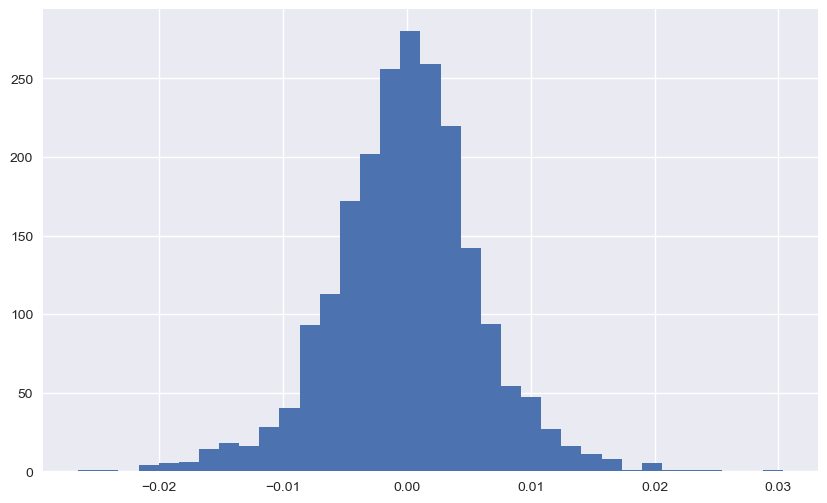

In [9]:
data['returns'].hist(bins=35, figsize=(10, 6));

### 回归特征制作
- 1.对于每个样本数据分别计算其前1天报酬率，前2天报酬率指标
- 2.画图展示特征结果，并用颜色来区分数值大小

In [10]:
lags = 2

In [11]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1,lags+1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [12]:
create_lags(data)

In [13]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544


In [14]:
data.dropna(inplace=True)

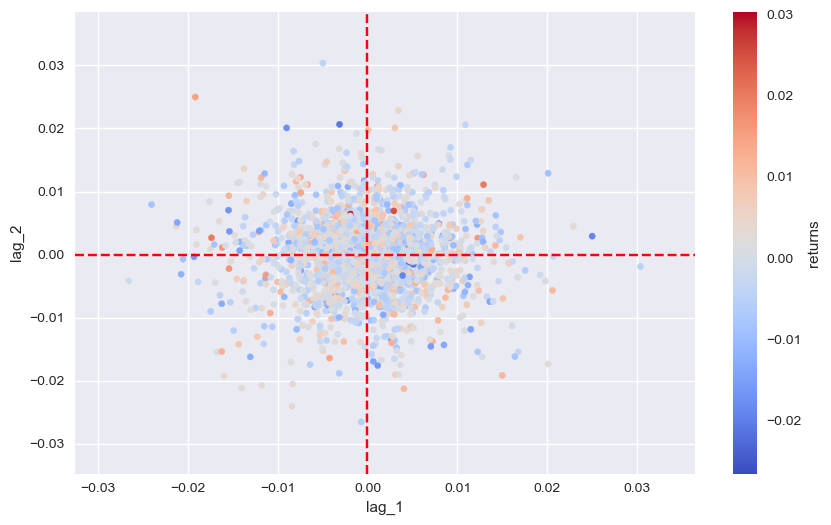

In [15]:
data.plot.scatter(x='lag_1',y='lag_2',c='returns',cmap='coolwarm',figsize=(10,6),colorbar=True)
plt.axvline(0,c='r',ls='--')
plt.axhline(0,c='r',ls='--')

### 使用工具包建立回归方程
- 1.训练模型并进行数值预测
- 2.指定不同的标签来对比结果
- 3.基于预测结果来规划买卖
- 4.试试水！

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
model = LinearRegression()

In [18]:
data['pos_ols_1'] = model.fit(data[cols],data['returns']).predict(data[cols])

In [19]:
data['pos_ols_2'] = model.fit(data[cols],data['direction']).predict(data[cols])

In [20]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2
Date,,,,,,,
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-0.000166,-0.000086
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,0.000017,0.040404
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-0.000244,-0.011756
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-0.000139,-0.043398
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984,-0.000022,0.002237


In [21]:
data[['pos_ols_1','pos_ols_2']] = np.where(data[['pos_ols_1','pos_ols_2']] > 0,1,-1)

In [22]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2
Date,,,,,,,
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-1,-1
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984,-1,1


In [23]:
data['reg_1'] = data['pos_ols_1'] * data['returns']
data['reg_2'] = data['pos_ols_2'] * data['returns']

In [24]:
data.head()

,EUR=,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,reg_1,reg_2
Date,,,,,,,,,
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-1,-1,0.006544,0.006544
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1,0.006544,0.006544
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1,-0.006984,-0.006984
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1,0.001310,0.001310
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984,-1,1,-0.001103,0.001103


In [25]:
data[['returns','reg_1','reg_2']].sum().apply(np.exp)

returns    0.810644
reg_1      0.942422
reg_2      1.339286
dtype: float64

In [26]:
(data['direction'] == data['pos_ols_1']).value_counts()

False    1093
True     1042
dtype: int64

In [27]:
(data['direction'] == data['pos_ols_2']).value_counts()

True     1096
False    1039
dtype: int64

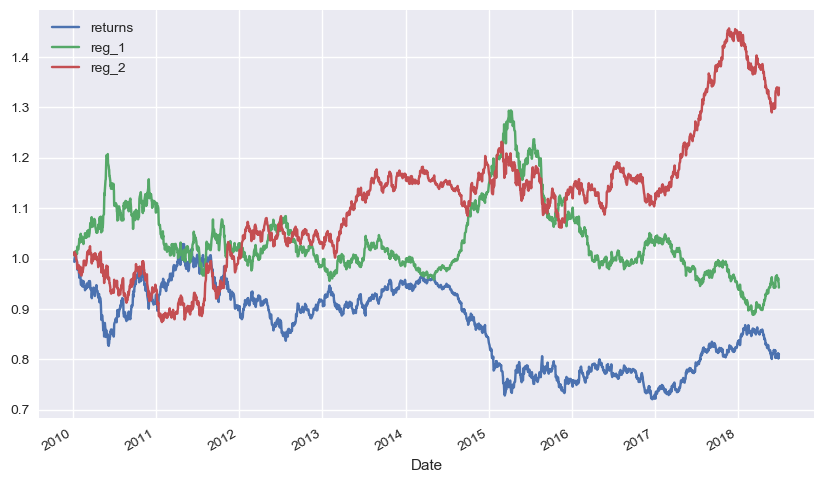

In [28]:
data[['returns','reg_1','reg_2']].cumsum().apply(np.exp).plot(figsize=(10,6))